In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

import time

c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sys.path.append("Scripts")

In [3]:
from graph_generator import *
from synthetic_data import *

0.9243297576904297


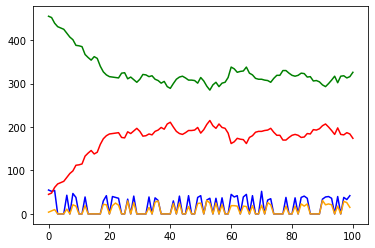

In [4]:
n_households  = 50
n_individuals = 350

household_var = 2

household_per_city_long = tf.convert_to_tensor([0  + tfp.distributions.Normal(0, household_var).sample(n_households),
                                                10  + tfp.distributions.Normal(0, household_var).sample(n_households),
                                                20 + tfp.distributions.Normal(0, household_var).sample(n_households),], dtype = tf.float32)

household_per_city_lat  = tf.convert_to_tensor([5  + tfp.distributions.Normal(0, household_var).sample(n_households),
                                                0  + tfp.distributions.Normal(0, household_var).sample(n_households),
                                                10 + tfp.distributions.Normal(0, household_var).sample(n_households),], dtype = tf.float32)

household_per_city = tf.convert_to_tensor([tfp.distributions.Dirichlet(1+tf.ones(n_households)).sample(),
                                           tfp.distributions.Dirichlet(  tf.ones(n_households)).sample(),
                                           tfp.distributions.Dirichlet(2+tf.ones(n_households)).sample(),], dtype = tf.float32)
initial_distribution = tf.convert_to_tensor([0.3, 0.3, 0.4], dtype = tf.float32)

households_simulator = households_simulation(household_per_city, household_per_city_long, household_per_city_lat)

city = households_simulator.assign_city(initial_distribution, n_individuals)

loc_I_H, households, households_coord = households_simulator.assign_household(city)

covariates_n = 2

M = 2
N = loc_I_H.shape[0]

individuals = np.linspace(0, N-1, N, dtype = int)+1

W = np.random.normal(1, 0, (N, 1))
for i in range(covariates_n-1):

    cov = np.random.normal(0, 1, (N, 1))
    W = np.concatenate((W, cov), axis =1)

W = tf.convert_to_tensor( W, dtype = tf.float32 )

T     = 100

input_0      = tuple([W])
input_kernel = (W, households_coord, loc_I_H)

simulator = compartmental_model(N, M, input_0, input_kernel, AB_initial, AB_SIS_spatial_transition)

beta_0      = tf.convert_to_tensor( [[-np.log(N/(2*25)-1), +0]], dtype = tf.float32 )
beta_lambda = tf.convert_to_tensor( [[+1,           +2]], dtype = tf.float32 )  
beta_gamma  = tf.convert_to_tensor( [[-1,           -1]], dtype = tf.float32 )  
psi = tf.convert_to_tensor([10], dtype = tf.float32 )

q     = tf.convert_to_tensor([[0.6, 0.6]], dtype = tf.float32)

individuals_sampled = 100
individuals_mask = tf.concat((tf.ones(individuals_sampled), tf.zeros(N -individuals_sampled)), axis =0)
individuals_mask = tf.reshape(individuals_mask, (N, 1))

q = q*individuals_mask

parameters_0     = tuple([beta_0])
parameters_kernel = beta_lambda, beta_gamma, psi

start = time.time()
data_X, data_Y = run(simulator, parameters_0, parameters_kernel, q, T)
print(time.time()-start)

scheduler = tfp.distributions.Bernoulli(probs=0.5).sample(data_Y.shape[0])

colorX = ["green", "red"]
colorY = ["blue", "orange"]
for k in range(1):
    for i in range(2):
        plt.plot(np.sum(data_X[:,k,:,i], axis =1), color = colorX[i])
        plt.plot(np.sum(data_Y[:,k,:,i], axis =1)*tf.cast(scheduler, dtype = tf.float32), color = colorY[i])

Y = data_Y[:,0,...]

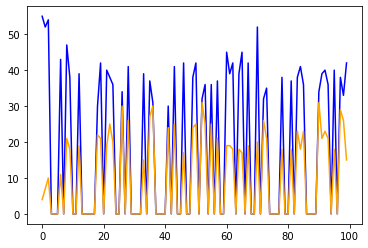

In [5]:
for k in range(1):
    for i in range(2):
        plt.plot(np.sum(data_Y[:,k,:,i], axis =1)*tf.cast(scheduler, dtype = tf.float32), color = colorY[i])

In [6]:
# np.save("Data/W.npy", W)
# np.save("Data/households_coord.npy", households_coord)
# np.save("Data/loc_I_H.npy", loc_I_H)
# np.save("Data/Y.npy", Y)
# np.save("Data/scheduler.npy", scheduler)
# np.save("Data/individuals_mask.npy", individuals_mask)

# Implement gradient

In [60]:
os.chdir("Scripts")
%run -i ABC.py
os.chdir("../")

In [71]:
# prior list
beta_0_prior      = tfp.distributions.Normal( loc = [0., 0.], scale = [3., 3.])
beta_lambda_prior = tfp.distributions.Normal( loc = [0., 0.], scale = [3., 3.])
beta_gamma_prior  = tfp.distributions.Normal( loc = [0., 0.], scale = [3., 3.])
q_prior           = tfp.distributions.Uniform(low = [0., 0.], high  = [1., 1.])
psi_prior         = tfp.distributions.Normal( loc = 15.,   scale  = 10.)

prior_list = [beta_0_prior, beta_lambda_prior, beta_gamma_prior, psi_prior, q_prior] 

# proposal list
proposal_std = 0.5
beta_0_proposal      = Gaussian_RW([proposal_std, proposal_std])
beta_lambda_proposal = Gaussian_RW([proposal_std, proposal_std])
beta_gamma_proposal  = Gaussian_RW([proposal_std, proposal_std])
logit_q_proposal     = Gaussian_RW([proposal_std, proposal_std])
psi_proposal         = Gaussian_RW([2*proposal_std])

proposal_list = [beta_0_proposal, beta_lambda_proposal, beta_gamma_proposal, psi_proposal, logit_q_proposal] 

# transform from parameters space to proposal space
beta_0_to_beta_0           = identity
beta_lambda_to_beta_lambda = identity
beta_gamma_to_beta_gamma   = identity
q_to_logitq                = logit
psi_to_psi                 = identity

to_proposal_space_list = [beta_0_to_beta_0, beta_lambda_to_beta_lambda, beta_gamma_to_beta_gamma, psi_to_psi, q_to_logitq] 
# transform from proposal space to parameter space
beta_0_to_beta_0           = identity
beta_lambda_to_beta_lambda = identity
beta_gamma_to_beta_gamma   = identity
logitq_to_q                = invlogit
psi_to_psi                 = identity


to_parameter_space_list = [beta_0_to_beta_0, beta_lambda_to_beta_lambda, beta_gamma_to_beta_gamma, psi_to_psi, logitq_to_q] 

In [72]:
# define the PMMH components
prior_parameter_ABC_PMC    = prior_parameter( prior_list)
proposal_parameter_ABC_PMC = proposal_parameter( proposal_list, to_proposal_space_list, to_parameter_space_list)


In [92]:
nr_simulation = 200
nr_samples = 100

model = (AB_initial, AB_SIS_spatial_transition)
input_model = (tuple([W]), (W, households_coord, loc_I_H))

parameters_split = 1

self = algorithm_ABC(model, input_model, parameters_split, 
               prior_parameter_ABC_PMC, proposal_parameter_ABC_PMC, 
               nr_simulation, nr_samples)

In [93]:
proposal_sample, proposal_sample_logprior, proposal_sample_logproposal = propose_0(self)
parameter_sample, parameter_sample_score = step(self, proposal_sample, proposal_sample_logprior, proposal_sample_logproposal, Y, scheduler, individuals_mask)

In [94]:
    input_0      = self.input_model[0]

    N = input_0[0].shape[0]

    parameters_0      = [tf.Variable(tf.expand_dims(parameter_sample[i], 0)) for i in range(self.parameters_split)]
    parameters_kernel = [tf.Variable(tf.expand_dims(parameter_sample[i], 0)) for i in range(self.parameters_split, len(parameter_sample)-1)]
    
    logit_parameter_emission = tf.Variable((tf.expand_dims(logit(tf.expand_dims(parameter_sample[-1], axis =1)), axis =0)))

In [95]:
os.chdir("Scripts")
%run -i Gradient_based.py
os.chdir("../")

In [96]:

parameters_0_wrapped      = [parameters_i*tf.ones((self.nr_simulation)+(parameters_i.shape)) for parameters_i in parameters_0]
parameters_kernel_wrapped = [parameters_i*tf.ones((self.nr_simulation)+(parameters_i.shape)) for parameters_i in parameters_kernel]
parameter_emission_wrapped = invlogit(logit_parameter_emission)*tf.ones((self.nr_simulation, 1, N, 1))*tf.reshape(individuals_mask, (1, 1)+individuals_mask.shape)

In [183]:
# like_list = []

# parameters_0_list = []
# parameters_kernel_list = []
# parameter_emission_list = []

# parameters_0_list.append(parameters_0)
# parameters_kernel_list.append(parameters_kernel)
# parameter_emission_list.append(invlogit(logit_parameter_emission))

for i in range(200):
    with tf.GradientTape() as tape:

        parameter_emission_wrapped = invlogit(logit_parameter_emission)*tf.ones((self.nr_simulation, 1, N, 1))*tf.reshape(individuals_mask, (1, 1)+individuals_mask.shape)
        like = -grad_loglikelihood_forward(self.ABC_calculator, parameters_0, parameters_kernel, parameter_emission_wrapped, Y, scheduler)

    grad_param_list = tape.gradient(like, [parameters_0, parameters_kernel, logit_parameter_emission])

    grad_parameters_0       = grad_param_list[0]
    grad_parameters_kernel  = grad_param_list[1]
    grad_parameter_emission = grad_param_list[2]

    parameters_0       = [tf.Variable(parameters_0[i]       - learning_rate_0[i]*grad_parameters_0[i]) for i in range(len(parameters_0))]
    parameters_kernel  = [tf.Variable(parameters_kernel[i]  - learning_rate_kernel[i]*grad_parameters_kernel[i]) for i in range(len(parameters_kernel))]
    logit_parameter_emission = tf.Variable(logit_parameter_emission - learning_rate_emission*grad_parameter_emission) 

    like_list.append(like)

    parameters_0_list.append(parameters_0)
    parameters_kernel_list.append(parameters_kernel)
    parameter_emission_list.append(invlogit(logit_parameter_emission))

    print("iteration "+str(i)+" with likelihood "+str(like.numpy()))
    print(grad_parameters_0)
    print(grad_parameters_kernel)
    print(grad_parameter_emission)

iteration 0 with likelihood 4222.8877
[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.30040857, 0.23520005]], dtype=float32)>]
[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.4113408 , 0.02503294]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.70675457, 0.45470673]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.33922762], dtype=float32)>]
tf.Tensor([[ 1.253765  -1.8271651]], shape=(1, 2), dtype=float32)
iteration 1 with likelihood 4225.3086
[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.00959922, -0.03624057]], dtype=float32)>]
[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.74201393, -0.01680821]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.16636264, -0.33740345]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.66149926], dtype=float32)>]
tf.Tensor([[-0.55006945 -0.5589038 ]], shape=(1, 2), dtype=float32)
iteration 2 with likelihood 

In [184]:
like_list = like_list[:-1]

In [185]:
parameters_0_list = parameters_0_list[:-2]
parameters_kernel_list = parameters_kernel_list[:-2]
parameter_emission_list = parameter_emission_list[:-2]


In [186]:
parameters_0 = parameters_0_list[-1]
parameters_kernel = parameters_kernel_list[-1]
logit_parameter_emission = tf.Variable(parameter_emission_list[-1])

In [187]:
parameters_kernel

[<tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[1.6365396, 2.7052104]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 2) dtype=float32, numpy=array([[-0.9115787, -1.1691556]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([9.141533], dtype=float32)>]

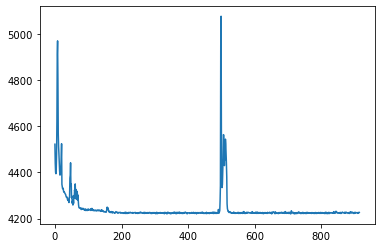

In [188]:
plt.plot(like_list)

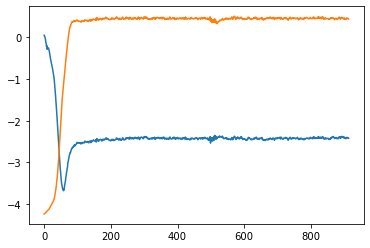

In [189]:
plt.plot(np.array([parameters_0_list[i] for i in range(len(parameters_0_list))])[:,0,0,0])
plt.plot(np.array([parameters_0_list[i] for i in range(len(parameters_0_list))])[:,0,0,1])

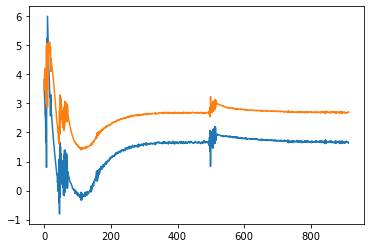

In [190]:
plt.plot(np.array([parameters_kernel_list[i][0] for i in range(len(parameters_0_list))])[:,0,0])
plt.plot(np.array([parameters_kernel_list[i][0] for i in range(len(parameters_0_list))])[:,0,1])

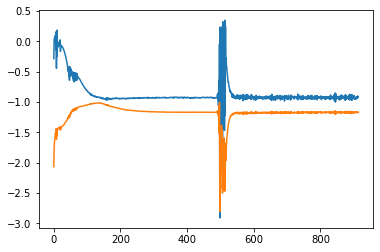

In [191]:
plt.plot(np.array([parameters_kernel_list[i][1] for i in range(len(parameters_0_list))])[:,0,0])
plt.plot(np.array([parameters_kernel_list[i][1] for i in range(len(parameters_0_list))])[:,0,1])

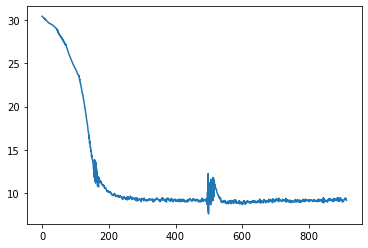

In [192]:
plt.plot(np.array([parameters_kernel_list[i][2] for i in range(len(parameters_0_list))])[:,0])

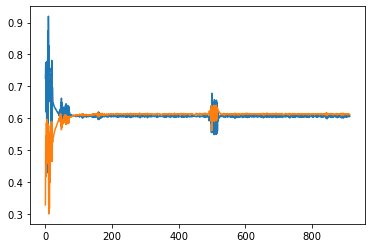

In [193]:
plt.plot(np.array([parameter_emission_list[i] for i in range(len(parameter_emission_list))])[:,0,0])
plt.plot(np.array([parameter_emission_list[i] for i in range(len(parameter_emission_list))])[:,0,1])

In [104]:
beta_0

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-2.1972246,  0.       ]], dtype=float32)>

In [59]:
beta_lambda

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 2.]], dtype=float32)>

In [33]:
processed_grads = list()

for g in grads:

    for sub_g in g:

        processed_grads.append(sub_g)

processed_params = list()

for param in [parameters_0, parameters_kernel, parameter_emission]:

    for sub_param in param:

        processed_grads.append(sub_param)

grads_and_vars = zip(processed_grads, processed_params)

In [34]:
	opt.apply_gradients(grads_and_vars)

In [35]:
opt

In [176]:
list([list([g for g in g_list]) for g_list in processed_grads])

[[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[32.46882  ,  5.6394386]], dtype=float32)>],
 [<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[146.35828, -98.49722]], dtype=float32)>,
  <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-416.6519 , -116.22106]], dtype=float32)>,
  <tf.Tensor: shape=(1,), dtype=float32, numpy=array([84.7296], dtype=float32)>],
 [<tf.Tensor: shape=(2,), dtype=float32, numpy=array([32331.244 ,  8036.6943], dtype=float32)>]]

In [122]:
with tf.GradientTape() as tape:
    parameter_emission_wrapped = parameter_emission*tf.ones((1, N, 1))
    LOGLIK = loglikelihood_forward(self.ABC_calculator, parameters_0, parameters_kernel, parameter_emission, Y, scheduler)

InvalidArgumentError: XLA compilation requires a fixed tensor list size. Set the max number of elements. This could also happen if you're using a TensorArray in a while loop that does not have its maximum_iteration set, you can fix this by setting maximum_iteration to a suitable value.

Stack trace for op definition: 
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\runpy.py", line 197, in _run_module_as_main
  return _run_code(code, main_globals, None,
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\runpy.py", line 87, in _run_code
  exec(code, run_globals)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
  app.launch_new_instance()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
  app.start()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
  self.io_loop.start()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
  self.asyncio_loop.run_forever()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\asyncio\base_events.py", line 601, in run_forever
  self._run_once()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\asyncio\base_events.py", line 1905, in _run_once
  handle._run()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\asyncio\events.py", line 80, in _run
  self._context.run(self._callback, *self._args)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
  await self.process_one()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
  await dispatch(*args)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
  await result
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
  reply_content = await reply_content
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
  res = shell.run_cell(
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
  return super().run_cell(*args, **kwargs)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
  result = self._run_cell(
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
  return runner(coro)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
  coro.send(None)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
  if await self.run_code(code, result, async_=asy):
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
  exec(code_obj, self.user_global_ns, self.user_ns)
File "C:\Users\loren\AppData\Local\Temp\ipykernel_424\551498939.py", line 2, in <cell line: 1>
  loglikelihood_forward(self.ABC_calculator, parameters_0, parameters_kernel, parameter_emission_wrapped, Y, scheduler)

	 [[{{node while/Cast_0/accumulator}}]] [Op:__forward_loglikelihood_forward_12040]

In [107]:
with tf.GradientTape() as tape:
    parameter_emission_wrapped = parameter_emission*tf.ones((self.nr_simulation, N, 1))
    parameters_0_wrapped = [parameters_0[i]*tf.ones((self.nr_simulation, parameters_0[i].shape[1])) for i in range(len(parameters_0))]
    parameters_kernel_wrapped = []
    for i in range(len(parameters_kernel)):

        if len(parameters_kernel[i].shape)==2:
            parameters_kernel_wrapped.append(parameters_kernel[i]*tf.ones((self.nr_simulation, parameters_kernel[i].shape[1])))
        else:
            parameters_kernel_wrapped.append(parameters_kernel[i]*tf.ones((self.nr_simulation,)))

    loglikelihood = loglikelihood_forward(self.ABC_calculator, parameters_0_wrapped, parameters_kernel_wrapped, parameter_emission_wrapped, Y, scheduler)

InvalidArgumentError: XLA compilation requires a fixed tensor list size. Set the max number of elements. This could also happen if you're using a TensorArray in a while loop that does not have its maximum_iteration set, you can fix this by setting maximum_iteration to a suitable value.

Stack trace for op definition: 
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\runpy.py", line 197, in _run_module_as_main
  return _run_code(code, main_globals, None,
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\runpy.py", line 87, in _run_code
  exec(code, run_globals)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
  app.launch_new_instance()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
  app.start()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
  self.io_loop.start()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
  self.asyncio_loop.run_forever()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\asyncio\base_events.py", line 601, in run_forever
  self._run_once()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\asyncio\base_events.py", line 1905, in _run_once
  handle._run()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\asyncio\events.py", line 80, in _run
  self._context.run(self._callback, *self._args)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
  await self.process_one()
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
  await dispatch(*args)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
  await result
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
  reply_content = await reply_content
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
  res = shell.run_cell(
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
  return super().run_cell(*args, **kwargs)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
  result = self._run_cell(
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
  return runner(coro)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
  coro.send(None)
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
  if await self.run_code(code, result, async_=asy):
File "c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
  exec(code_obj, self.user_global_ns, self.user_ns)
File "C:\Users\loren\AppData\Local\Temp\ipykernel_424\326531232.py", line 12, in <cell line: 1>
  loglikelihood = loglikelihood_forward(self.ABC_calculator, parameters_0_wrapped, parameters_kernel_wrapped, parameter_emission_wrapped, Y, scheduler)

	 [[{{node while/Cast_0/accumulator}}]] [Op:__forward_loglikelihood_forward_8939]

In [71]:
loglikelihood

<tf.Tensor: shape=(), dtype=float32, numpy=-22148.113>

In [ ]:
	with tf.GradientTape() as tape:
		y = fu(x1, x2)